In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from functions.hyperloglog import HashLogLog, HyperLogLog
from functions.kmeans import KMeansClustering, elbow_method
from functions.data_preprocess import remove_html_tags, preprocess, tfidf_svd


# 1. Hashing

## Sequentially adding data to the HLL

In [2]:
log2m, bits = 6, 32

HLL_6 = HyperLogLog(log2m=log2m, bits=bits)

hll_6 = HLL_6.structure('hash.txt')

print(hll_6)

[23, 21, 23, 21, 23, 25, 22, 23, 23, 20, 21, 23, 21, 20, 22, 22, 21, 26, 20, 21, 26, 22, 21, 22, 22, 22, 20, 22, 25, 23, 26, 22, 24, 21, 21, 21, 21, 20, 20, 21, 24, 21, 24, 25, 22, 21, 25, 25, 25, 22, 20, 24, 22, 26, 20, 24, 24, 26, 21, 26, 20, 25, 22, 21]


## Cardinality and (relative) error of the filter

In [3]:
estimate_6 = HLL_6.cardinality(hll_6)
error_6 = HLL_6.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {}'.format(estimate_6, error_6))

Total bits: 32
Bits for the buckets: 6
Estimate: 139604896
Error: 0.13


### Observation
Maybe we can do a little bit better by increasing the lenght of the root to 11 bits. This seems to be a good point for the tradeoff between error and efficiency!

In [4]:
log2m, bits = 11, 32

HLL_11 = HyperLogLog(log2m=log2m, bits=bits)

hll_11 = HLL_11.structure('hash.txt')

estimate_11 = HLL_11.cardinality(hll_11)

error_11 = HLL_11.error()

print('Total bits: {}\nBits for the buckets: {}'.format(bits, log2m))
print('Estimate: {}\nError: {:.3f}'.format(estimate_11, error_11))

Total bits: 32
Bits for the buckets: 11
Estimate: 123189077
Error: 0.023


# Real error
To compute the real error of the algorithm we used, we have to count the exact number of unique elements that appear in the `hash.txt` file. In order to do that, there are severel options. One of those is to use shell commands, and that's what we've chosen to do.

In [5]:
!sort hash.txt | uniq | wc -l

125000000


# 2. Clustering

## 2.0 Preprocess data

### Data cleaning

In [3]:
data_path = './data/Reviews.csv'

data = pd.read_csv(data_path)

In [4]:
# Converting the reviews to lowercase and removing html tags
data['Text'] = data['Text'].str.lower()

# Removing html tags
data['Text'] = data['Text'].apply(remove_html_tags)

# Removing punctuation, special characters, digits 
# Tokenizing, lemmatizing the data
data['Text'] = data['Text'].apply(preprocess)

KeyboardInterrupt: 

In [13]:
data.to_csv('./data/clean_data.csv')

### Read clean + tfidf + svd

In [43]:
clean_data_path = './data/clean_data.csv'
clean_data = pd.read_csv(clean_data_path)
clean_data['Text'].fillna('', inplace=True)

In [44]:
data_reduced = tfidf_svd(clean_data['Text'])

In [45]:
data_reduced.shape

(568454, 15)

In [46]:
# We are going to use the elbow method to select number of clusters at some point!
model = KMeansClustering(n_clusters=10)

model.fit(data_reduced)

Number of clusters = 1	Number of iterations = 2
Number of clusters = 2	Number of iterations = 50
Number of clusters = 3	Number of iterations = 26
Number of clusters = 4	Number of iterations = 41
Number of clusters = 5	Number of iterations = 27
Number of clusters = 6	Number of iterations = 30
Number of clusters = 7	Number of iterations = 35
Number of clusters = 8	Number of iterations = 34
Number of clusters = 9	Number of iterations = 28
Number of clusters = 10	Number of iterations = 25
Number of clusters = 11	Number of iterations = 44
Number of clusters = 12	Number of iterations = 50
Number of clusters = 13	Number of iterations = 42
Number of clusters = 14	Number of iterations = 30
Number of clusters = 15	Number of iterations = 29
Number of clusters = 16	Number of iterations = 33
Number of clusters = 17	Number of iterations = 30
Number of clusters = 18	Number of iterations = 50
Number of clusters = 19	Number of iterations = 35
Number of clusters = 20	Number of iterations = 34


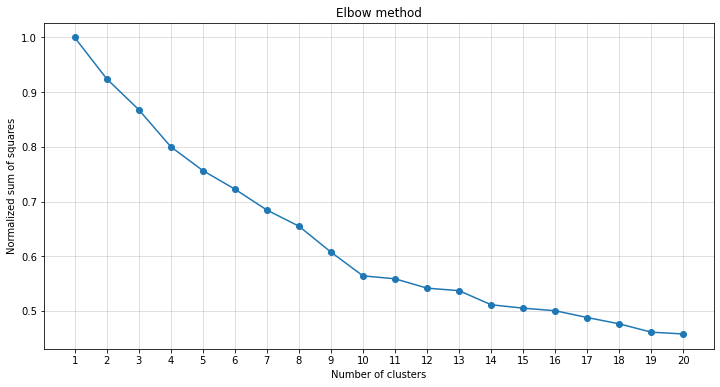

In [158]:
elbow_method(data_reduced, K=20)

In [148]:
# We are going to use the elbow method to select number of clusters at some point!
model = KMeansClustering(n_clusters=10)

model.fit(data_reduced)

KeyboardInterrupt: 

In [140]:
model = KMeansClustering(n_clusters=10)

model.fit(X)

In [58]:
labels = model.labels_

In [97]:
test = corpus[np.where(labels == 3)[0]]

In [98]:
vect = TfidfVectorizer(min_df=0.01, max_df=0.4)
vecs = vect.fit_transform(test)
vecs

<44824x704 sparse matrix of type '<class 'numpy.float64'>'
	with 1112573 stored elements in Compressed Sparse Row format>

In [99]:
feature_names = vect.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

In [100]:
Cloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(df.T.sum(axis=1)) 

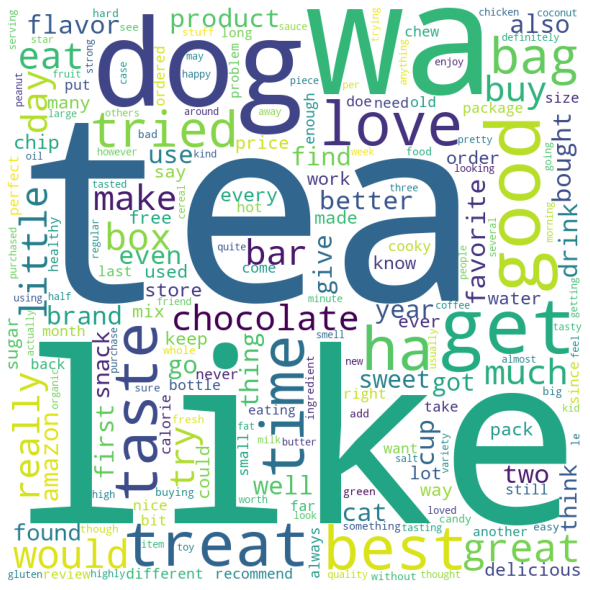

In [101]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(Cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()